In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from tabulate import tabulate
from sklearn.cross_decomposition import PLSRegression
import mlflow

path = 'SAMPLE_DATA_SET.xlsx'

# Read and load dataset
df= pd.read_excel(path, sheet_name=[0, 1])

/home/giovanni/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


INPUT DATA

In [2]:
X =df.get(0)
X = (X.iloc[:,1:]).values
X = X.T
print(X.shape)

(839, 444)


OUTPUT DATA

In [3]:
Y =df.get(1)
Y = (Y.iloc[:,:]).values
print(Y.shape)

(839, 2)


0.05 ripartition
Param 1


2024/05/09 18:38:59 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'PLS Param 1 - 0.05 ripartition'.
2024/05/09 18:38:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PLS Param 1 - 0.05 ripartition, version 1
Created version '1' of model 'PLS Param 1 - 0.05 ripartition'.


Param 2


2024/05/09 18:39:03 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'PLS Param 2 - 0.05 ripartition'.
2024/05/09 18:39:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PLS Param 2 - 0.05 ripartition, version 1
Created version '1' of model 'PLS Param 2 - 0.05 ripartition'.


0.1 ripartition
Param 1


2024/05/09 18:39:08 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'PLS Param 1 - 0.1 ripartition'.
2024/05/09 18:39:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PLS Param 1 - 0.1 ripartition, version 1
Created version '1' of model 'PLS Param 1 - 0.1 ripartition'.


Param 2


2024/05/09 18:39:12 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'PLS Param 2 - 0.1 ripartition'.
2024/05/09 18:39:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PLS Param 2 - 0.1 ripartition, version 1
Created version '1' of model 'PLS Param 2 - 0.1 ripartition'.


0.15 ripartition
Param 1


2024/05/09 18:39:14 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'PLS Param 1 - 0.15 ripartition'.
2024/05/09 18:39:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PLS Param 1 - 0.15 ripartition, version 1
Created version '1' of model 'PLS Param 1 - 0.15 ripartition'.


Param 2


2024/05/09 18:39:19 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'PLS Param 2 - 0.15 ripartition'.
2024/05/09 18:39:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PLS Param 2 - 0.15 ripartition, version 1
Created version '1' of model 'PLS Param 2 - 0.15 ripartition'.


0.2 ripartition
Param 1


2024/05/09 18:39:22 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'PLS Param 1 - 0.2 ripartition'.
2024/05/09 18:39:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PLS Param 1 - 0.2 ripartition, version 1
Created version '1' of model 'PLS Param 1 - 0.2 ripartition'.


Param 2


2024/05/09 18:39:26 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'PLS Param 2 - 0.2 ripartition'.
2024/05/09 18:39:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PLS Param 2 - 0.2 ripartition, version 1
Created version '1' of model 'PLS Param 2 - 0.2 ripartition'.


0.25 ripartition
Param 1


2024/05/09 18:39:29 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'PLS Param 1 - 0.25 ripartition'.
2024/05/09 18:39:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PLS Param 1 - 0.25 ripartition, version 1
Created version '1' of model 'PLS Param 1 - 0.25 ripartition'.


Param 2


2024/05/09 18:39:34 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'PLS Param 2 - 0.25 ripartition'.
2024/05/09 18:39:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PLS Param 2 - 0.25 ripartition, version 1
Created version '1' of model 'PLS Param 2 - 0.25 ripartition'.


0.3 ripartition
Param 1


2024/05/09 18:39:37 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'PLS Param 1 - 0.3 ripartition'.
2024/05/09 18:39:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PLS Param 1 - 0.3 ripartition, version 1
Created version '1' of model 'PLS Param 1 - 0.3 ripartition'.


Param 2


2024/05/09 18:39:42 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'PLS Param 2 - 0.3 ripartition'.
2024/05/09 18:39:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PLS Param 2 - 0.3 ripartition, version 1
Created version '1' of model 'PLS Param 2 - 0.3 ripartition'.


0.35 ripartition
Param 1


2024/05/09 18:39:45 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'PLS Param 1 - 0.35 ripartition'.
2024/05/09 18:39:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PLS Param 1 - 0.35 ripartition, version 1
Created version '1' of model 'PLS Param 1 - 0.35 ripartition'.


Param 2


2024/05/09 18:39:49 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'PLS Param 2 - 0.35 ripartition'.
2024/05/09 18:39:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PLS Param 2 - 0.35 ripartition, version 1
Created version '1' of model 'PLS Param 2 - 0.35 ripartition'.


0.4 ripartition
Param 1


2024/05/09 18:39:53 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'PLS Param 1 - 0.4 ripartition'.
2024/05/09 18:39:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PLS Param 1 - 0.4 ripartition, version 1
Created version '1' of model 'PLS Param 1 - 0.4 ripartition'.


Param 2


2024/05/09 18:40:02 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'PLS Param 2 - 0.4 ripartition'.
2024/05/09 18:40:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PLS Param 2 - 0.4 ripartition, version 1
Created version '1' of model 'PLS Param 2 - 0.4 ripartition'.


0.45 ripartition
Param 1


2024/05/09 18:40:03 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'PLS Param 1 - 0.45 ripartition'.
2024/05/09 18:40:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PLS Param 1 - 0.45 ripartition, version 1
Created version '1' of model 'PLS Param 1 - 0.45 ripartition'.


Param 2


2024/05/09 18:40:07 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'PLS Param 2 - 0.45 ripartition'.
2024/05/09 18:40:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PLS Param 2 - 0.45 ripartition, version 1
Created version '1' of model 'PLS Param 2 - 0.45 ripartition'.


0.5 ripartition
Param 1


2024/05/09 18:40:11 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'PLS Param 1 - 0.5 ripartition'.
2024/05/09 18:40:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PLS Param 1 - 0.5 ripartition, version 1
Created version '1' of model 'PLS Param 1 - 0.5 ripartition'.


Param 2


2024/05/09 18:40:17 WARNING mlflow.utils.requirements_utils: Found lz4 version (3.1.3+dfsg) contains a local version label (+dfsg). MLflow logged a pip requirement for this package as 'lz4==3.1.3' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'PLS Param 2 - 0.5 ripartition'.
2024/05/09 18:40:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PLS Param 2 - 0.5 ripartition, version 1
Created version '1' of model 'PLS Param 2 - 0.5 ripartition'.


╔════════════════╦══════════════╦══════════════╦══════════════╦══════════════╦═════════════╦═════════════╦═════════╦═════════╗
║   Test size(%) ║   Best(MSE1) ║   Best(MSE2) ║   Mean(MSE1) ║   Mean(MSE2) ║   Var(MSE1) ║   Var(MSE2) ║   Seed1 ║   Seed2 ║
╠════════════════╬══════════════╬══════════════╬══════════════╬══════════════╬═════════════╬═════════════╬═════════╬═════════╣
║              5 ║      1.10662 ║     0.879737 ║      1.87806 ║      2.26929 ║   0.207117  ║   0.395335  ║      48 ║      87 ║
║             10 ║      1.31144 ║     1.38535  ║      1.87563 ║      2.20087 ║   0.100209  ║   0.165881  ║      52 ║      47 ║
║             15 ║      1.42002 ║     1.34171  ║      1.88316 ║      2.17854 ║   0.0717815 ║   0.119094  ║      50 ║      47 ║
║             20 ║      1.39654 ║     1.54323  ║      1.92252 ║      2.19797 ║   0.0488025 ║   0.0947571 ║      88 ║      87 ║
║             25 ║      1.53091 ║     1.60888  ║      1.95536 ║      2.18966 ║   0.0360762 ║   0.0699232 ║     

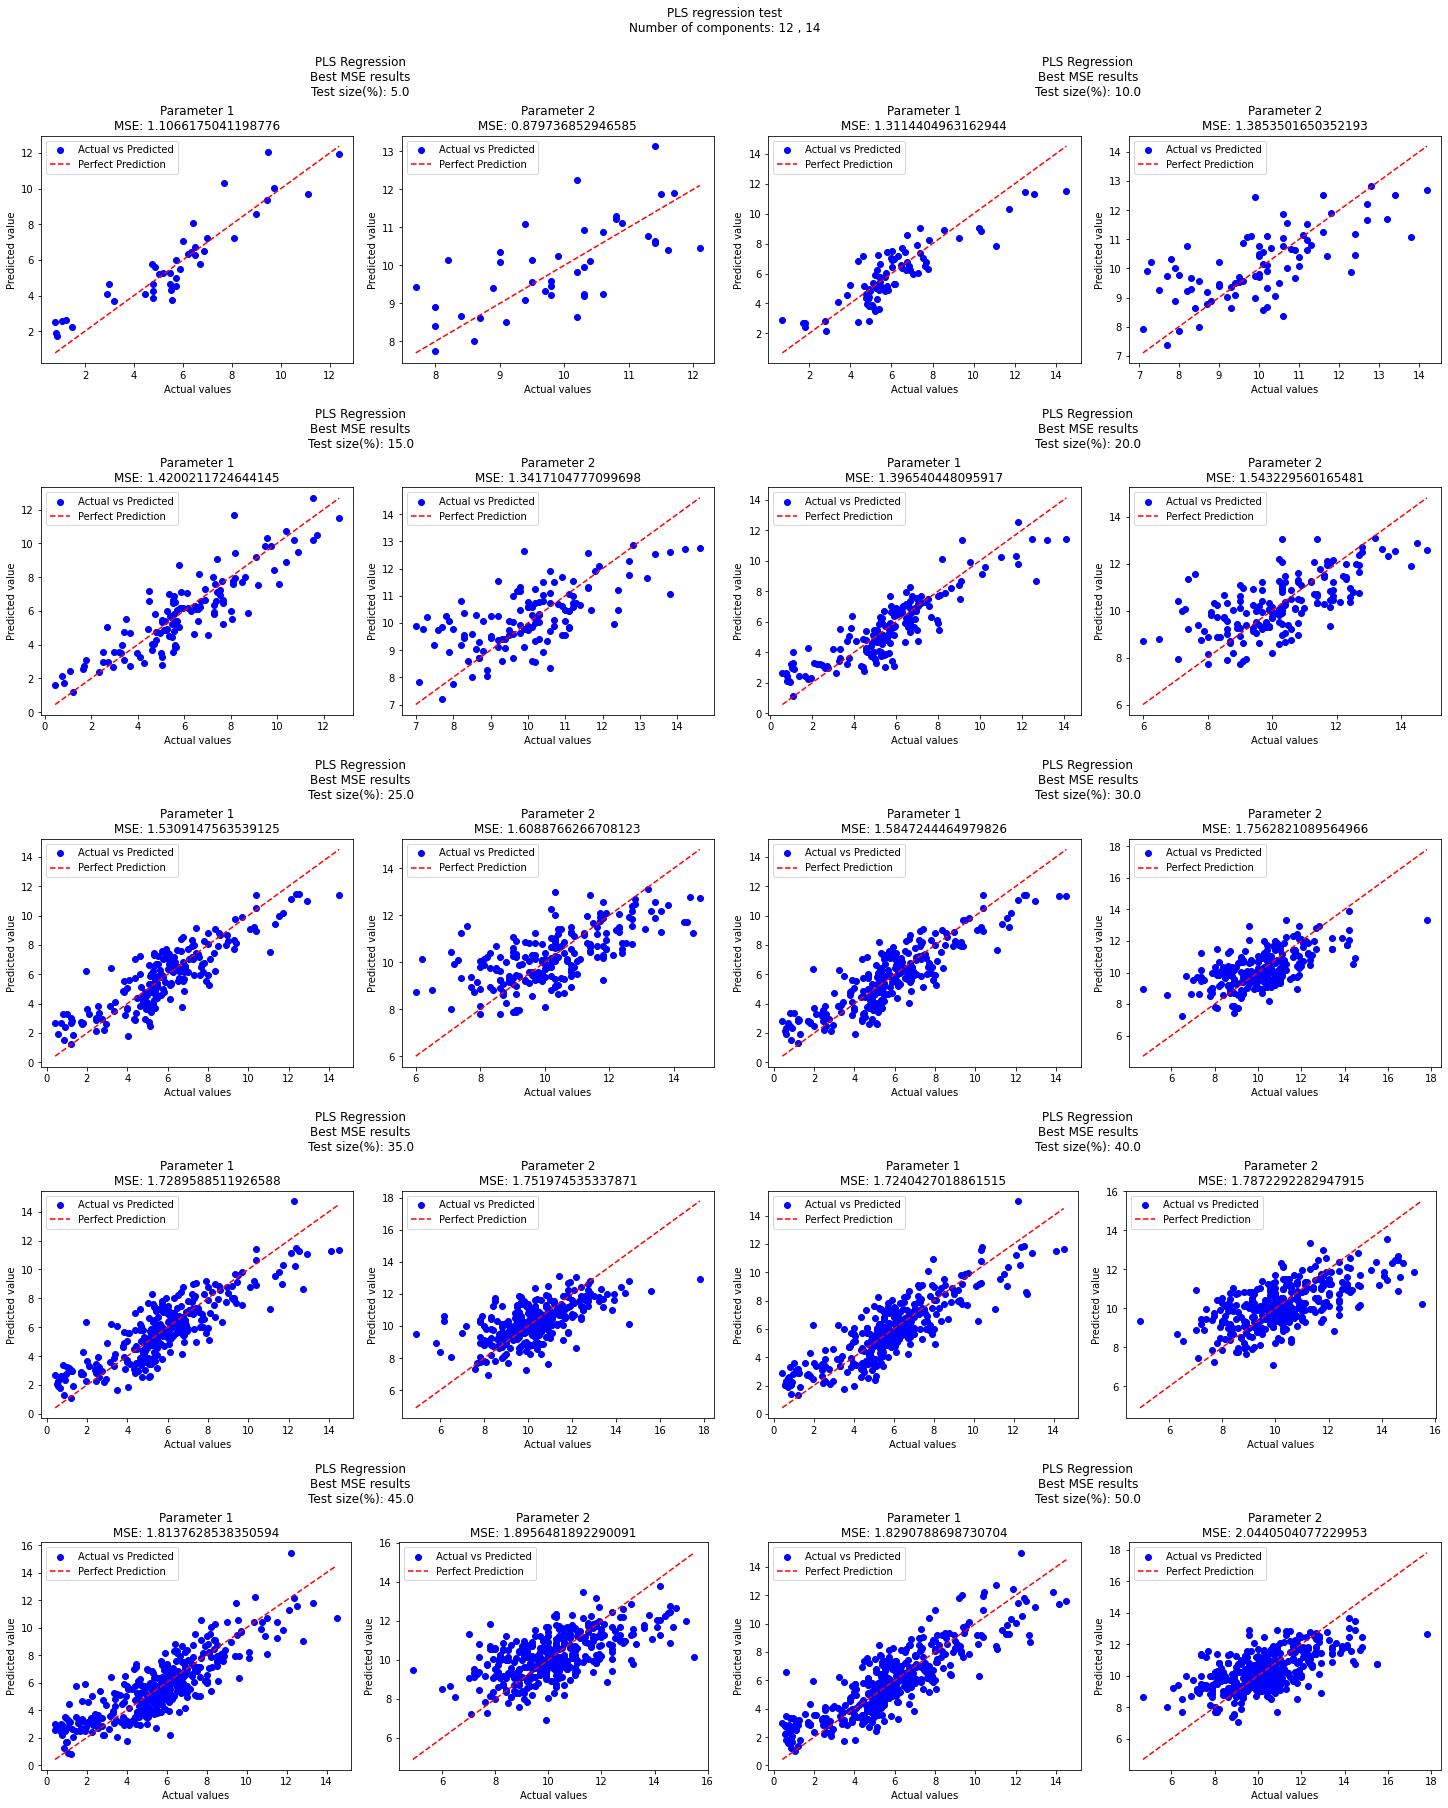

In [7]:
mlflow.set_experiment("PLS Best")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

n_components_1 = 12
n_components_2 = 14
# number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [i / 100 for i in range(5, 55, 5)]
results = [] 

# create 5x2 subfigs
fig = plt.figure(constrained_layout=True, figsize=(20, 25))
fig.suptitle('PLS regression test'+"\n"+ f"Number of components: {n_components_1} , {n_components_2}"+"\n")
subfigs = fig.subfigures(nrows=5, ncols=2).flatten()
k = 0

for ripartition in ripartisions:
    run_name = str(ripartition) + " ripartition"
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param('ripartition', ripartition)    
        print(str(ripartition) + " ripartition" )
        '''PARAM 1'''

        MSE_param1 = []
        best_MSE_1 = 100000000
        best_data_1 = {"Y_test": None, "Y_pred": None, "seed": None}
        print("Param 1")
        i = 0
        for i in range(trials):
            # Tell mlflow to log the following parameters for the experiments dashboard
            # Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:, 0], test_size=ripartition,
                                                                   random_state=seeds[i])
            pls_model = PLSRegression(n_components=n_components_1)

            pls_model.fit(X_train, Y_train)

            # Make predictions using the testing set
            Y_pred_pls = pls_model.predict(X_test)

            # save MSE of the first parameters
            MSE_param1.append(mean_squared_error(Y_test, Y_pred_pls))

            # check if this is the best model in terms of MSE
            if MSE_param1[-1] < best_MSE_1:
                best_MSE_1 = MSE_param1[-1]
                best_data_1["Y_test"] = Y_test
                best_data_1["Y_pred"] = Y_pred_pls
                best_data_1["seed"] = seeds[i]
        
        
        mlflow.log_metric("Best_MSE1", best_MSE_1)
        mlflow.log_metric("Mean_MSE1", np.mean(MSE_param1))
        mlflow.log_metric("Var_MSE1", np.var(MSE_param1))
        mlflow.sklearn.log_model(
            sk_model=pls_model,
            artifact_path="sklearn-model",
            input_example=X_train,
            registered_model_name=f"PLS Param 1 - {ripartition} ripartition",
        )

        
        '''PARAM 2'''
        MSE_param2 = []
        best_MSE_2 = 100000000
        best_data_2 = {"Y_test": None, "Y_pred": None, "seed": None}
        print("Param 2")
        i = 0
        for i in range(trials):
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:, 1], test_size=ripartition,
                                                                    random_state=seeds[i])
            pls_model = PLSRegression(n_components=n_components_2)

            pls_model.fit(X_train, Y_train)

            # Make predictions using the testing set
            Y_pred_pls = pls_model.predict(X_test)

            # save MSE of the second parameters
            MSE_param2.append(mean_squared_error(Y_test, Y_pred_pls))

            # check if this is the best model in terms of MSE
            if MSE_param2[-1] < best_MSE_2:
                best_MSE_2 = MSE_param2[-1]
                best_data_2["Y_test"] = Y_test
                best_data_2["Y_pred"] = Y_pred_pls
                best_data_2["seed"] = seeds[i]

        results.append([str(ripartition * 100), str(best_MSE_1), str(best_MSE_2),
                            (np.mean(MSE_param1)), str(np.mean(MSE_param2)), str(np.var(MSE_param1)),
                            str(np.var(MSE_param2)),
                            best_data_1["seed"], best_data_2["seed"]])
        
        
        mlflow.log_metric("Best_MSE2", best_MSE_2)
        mlflow.log_metric("Mean_MSE2", np.mean(MSE_param2))
        mlflow.log_metric("Var_MSE2", np.var(MSE_param2))
        mlflow.sklearn.log_model(
            sk_model=pls_model,
            input_example=X_train,
             artifact_path="sklearn-model",
            registered_model_name=f"PLS Param 2 - {ripartition} ripartition",
        )


        '''PLOT THE BEST MODELS'''
        subfigs[k].suptitle("PLS Regression" + "\n" + "Best MSE results" + "\n" + f"Test size(%): {ripartition * 100}")
        # create 1x2 subplots per subfig
        axs = subfigs[k].subplots(nrows=1, ncols=2)
        axs[0].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
        axs[0].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                        [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
        axs[0].legend()
        axs[0].set_xlabel("Actual values")
        axs[0].set_ylabel("Predicted value")
        axs[0].set_title("Parameter 1"+"\n"+ "MSE: "+ str(best_MSE_1))
        axs[1].scatter(best_data_2["Y_test"], best_data_2["Y_pred"], c='blue', label='Actual vs Predicted')
        axs[1].plot([min(best_data_2["Y_test"]), max(best_data_2["Y_test"])],
                        [min(best_data_2["Y_test"]), max(best_data_2["Y_test"])], '--', c='red', label='Perfect Prediction')
        axs[1].legend()
        axs[1].set_xlabel("Actual values")
        axs[1].set_ylabel("Predicted value")
        axs[1].set_title("Parameter 2" + "\n"+ "MSE: "+ str(best_MSE_2))
        k += 1

'''SHOW RESULTS'''
headers = ["Test size(%)", "Best(MSE1)", "Best(MSE2)", "Mean(MSE1)", "Mean(MSE2)", "Var(MSE1)", "Var(MSE2)","Seed1","Seed2"]

print(tabulate(results, headers, tablefmt="double_outline"))
    
